In [10]:
from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import numpy as np
%matplotlib inline

import geopandas as gpd

# Notebook to create training data for Phoenix land classification

#### First try to use the Human Built Up and Settlement Extent raster

In [36]:
dataset = gdal.Open('data/phoenix/USA_15U_hbase_human_built_up_and_settlement_extent_utm_30m.tif', gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
print('Number of bands in image: {n}'.format(n=num_bands))

# How many rows and columns?
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Image size is: {r} rows x {c} columns'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.GetDescription()
metadata = dataset.GetMetadata()

Number of bands in image: 1
Image size is: 5205 rows x 14920 columns


In [37]:
# What driver was used to open the raster?
driver = dataset.GetDriver()
print('Raster driver: {d}\n'.format(d=driver.ShortName))

Raster driver: GTiff



In [38]:
# Initialize a 3d array -- size based on raster dimensions
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount))

# Allocate array using the first band's datatype
image_datatype = dataset.GetRasterBand(1).DataType

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset

for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()


In [5]:
image.shape

(5205, 14920, 1)

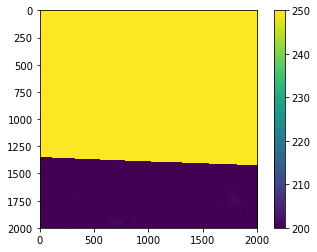

In [39]:
plt.imshow(image[:2000,:2000,0])
plt.colorbar()

In [32]:
np.histogram(image)

(array([30235404,        0,        0,        0,        0,        0,
               0,        0,        0, 47423196]),
 array([200. , 205.5, 211. , 216.5, 222. , 227.5, 233. , 238.5, 244. ,
        249.5, 255. ]))

#### ---> OK I haven't figured out this format yet. Anyway. Try with the Phoenix zoning shapefile.

# Import Phoenix Zoning shapefile

In [16]:
path = "data/phoenix/Zoning/Zoning.shp"
shp = gpd.GeoDataFrame.from_file(path)
print("Polygons, attributes: ",shp.shape)
shp.head(3)

('Polygons, attributes: ', (8848, 22))


,OBJECTID,ACRES,ZPREFIX,ZCASE,ZREVISION,ZYEAR,SPPREFIX,SPCASE,SPREVISION,SPYEAR,...,DATE_APPRO,LABEL1,ORD_NUM,HISTORIC,GEN_ZONE,INSERT_DAT,UPDATE_DAT,ANID,TOD,geometry
0,983,20.03,Z,290,,80,,,,,...,,R-3*,,,MF Residential,2016-05-06T13:45:24.000Z,2017-04-12T11:09:07.000Z,159938,,"POLYGON ((656017.2341840066 964499.5627548895,..."
1,923,12.93,,,,,,,,,...,,R1-6,,,SF Residential,2016-05-06T13:45:24.000Z,2016-05-24T08:00:36.000Z,159954,,"POLYGON ((654076.7972946508 900319.9415602018,..."
2,933,1.72,Z,32,,96,,,,,...,,C-2*,,,Commercial,2016-05-06T13:45:24.000Z,2017-04-12T11:09:06.000Z,159960,,"POLYGON ((653191.3995617718 935215.3520804092,..."


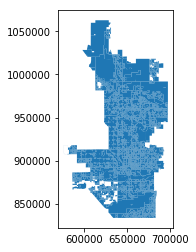

In [18]:
shp.plot()

### What unique categories?
Note they are sub-grouped into the 'Gen Zone' field below. We can use that.

In [20]:
shp.ZONING.value_counts().head(20)

C-2       1475
R1-6       681
R-3        662
R-5        624
C-1        482
P-1        411
R-4        394
C-O        362
R1-10      323
S-1        320
R-2        317
R1-8       281
C-3        229
A-1        228
R-3A       220
RE-35      142
CP/GCP     135
R1-18      122
PCD        120
PSC        103
Name: ZONING, dtype: int64

In [21]:
shp.GEN_ZONE.value_counts().head(20)

Commercial         3314
MF Residential     2574
SF Residential     2272
Industrial          572
Downtown Code        98
County               10
Non-Developable       6
Commerical            1
                      1
Name: GEN_ZONE, dtype: int64

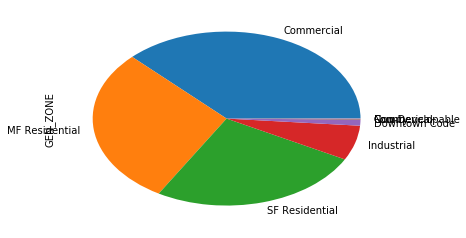

In [41]:
shp.GEN_ZONE.value_counts().head(20).plot(kind='pie')

# But note, this is referring to number of polygons not area.

# Label each polygon as (1) residential; or (2) urban non-residential.


In [29]:
def make_category(zoning_cat):
    if str(zoning_cat)[:2] == "MF":
        return 1
    elif str(zoning_cat)[:2] == "SF":
        return 1
    else:
        return 2


In [30]:
shp['cat']=shp['GEN_ZONE'].apply(make_category)
shp.head(4)

,OBJECTID,ACRES,ZPREFIX,ZCASE,ZREVISION,ZYEAR,SPPREFIX,SPCASE,SPREVISION,SPYEAR,...,LABEL1,ORD_NUM,HISTORIC,GEN_ZONE,INSERT_DAT,UPDATE_DAT,ANID,TOD,geometry,cat
0,983,20.03,Z,290,,80,,,,,...,R-3*,,,MF Residential,2016-05-06T13:45:24.000Z,2017-04-12T11:09:07.000Z,159938,,"POLYGON ((656017.2341840066 964499.5627548895,...",1
1,923,12.93,,,,,,,,,...,R1-6,,,SF Residential,2016-05-06T13:45:24.000Z,2016-05-24T08:00:36.000Z,159954,,"POLYGON ((654076.7972946508 900319.9415602018,...",1
2,933,1.72,Z,32,,96,,,,,...,C-2*,,,Commercial,2016-05-06T13:45:24.000Z,2017-04-12T11:09:06.000Z,159960,,"POLYGON ((653191.3995617718 935215.3520804092,...",2
3,984,9.41,Z,268,,82,,,,,...,IND.PK.*,,,Industrial,2016-05-06T13:45:24.000Z,2017-04-12T11:08:54.000Z,160000,,"POLYGON ((639674.5464530056 964461.5722175199,...",2


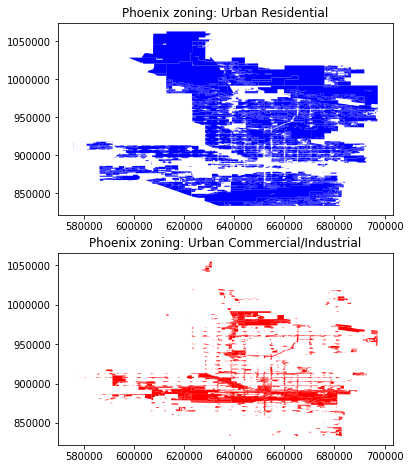

In [59]:
titles = ["Urban Residential","Urban Commercial/Industrial"]
cols = ['blue','red']

fig = plt.figure(figsize=[6,12])
for i in range(2):
    ax = plt.subplot(3,1,i+1)
    shp[shp.cat == i+1].plot(ax = ax,color=cols[i])
    ax.set_title("Phoenix zoning: "+ titles[i])
    

# Load Phoenix Landsat Image

In [53]:
dataset = gdal.Open('data/phoenix/phoenix_SM.tif', gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
print('Number of bands in image: {n}'.format(n=num_bands))

# How many rows and columns?
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Image size is: {r} rows x {c} columns'.format(r=rows, c=cols))

Number of bands in image: 12
Image size is: 266 rows x 330 columns


In [54]:
# Initialize a 3d array -- size based on raster dimensions
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount))

# Allocate array using the first band's datatype
image_datatype = dataset.GetRasterBand(1).DataType

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset

for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()



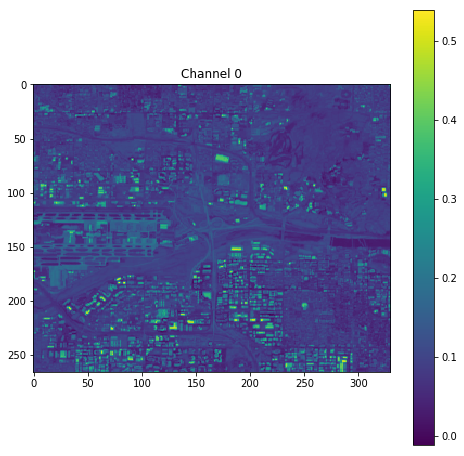

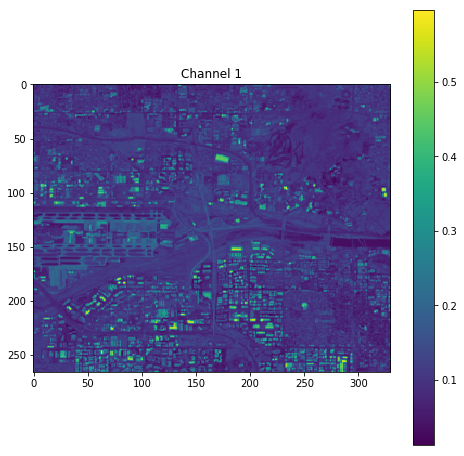

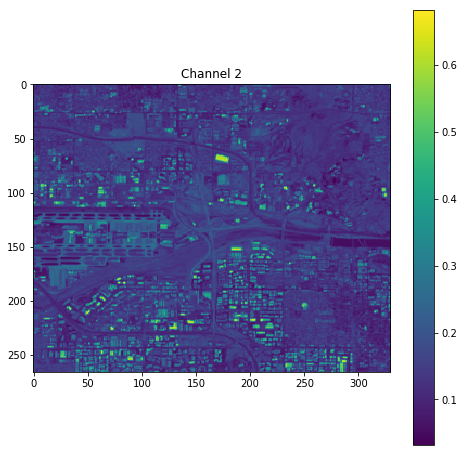

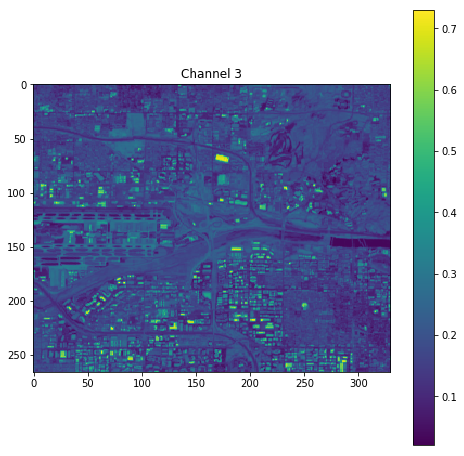

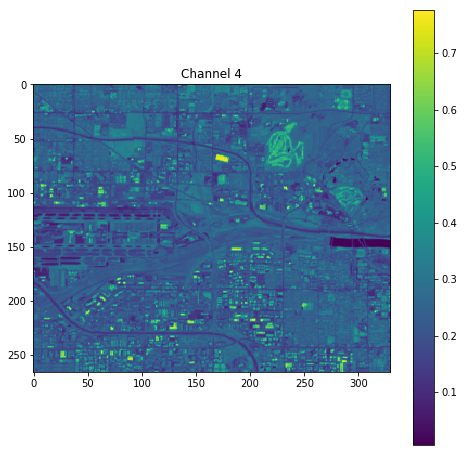

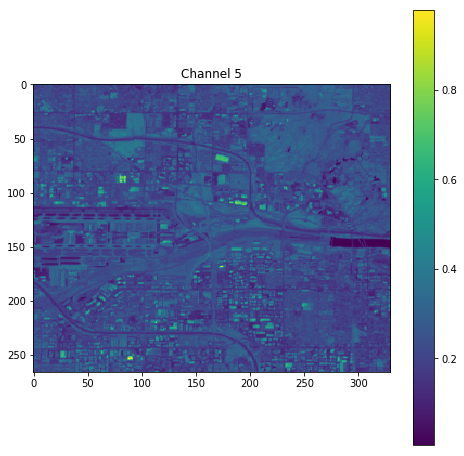

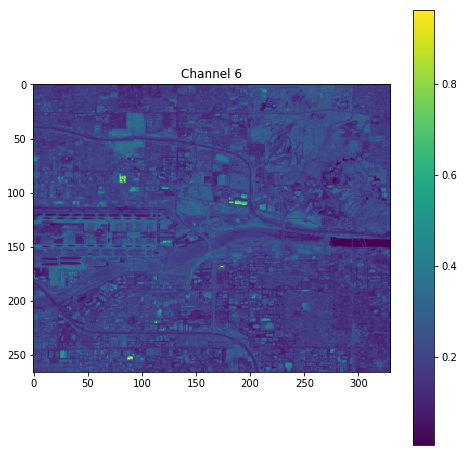

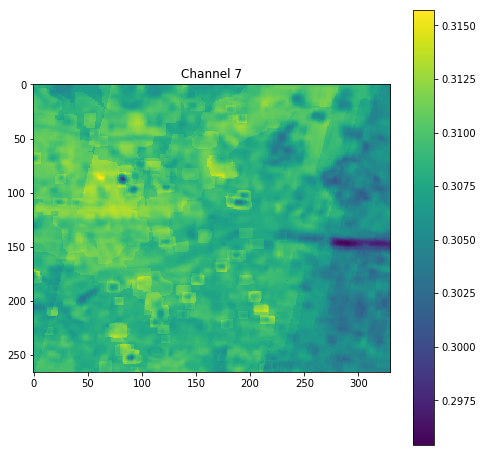

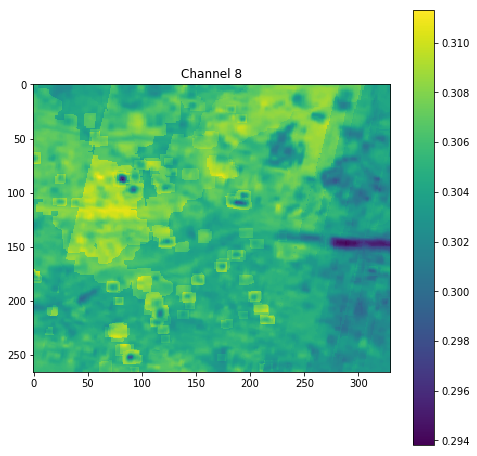

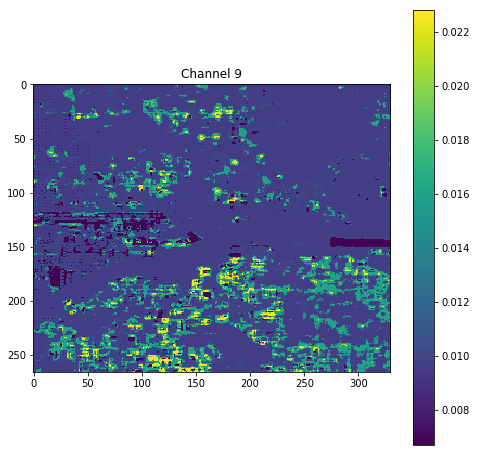

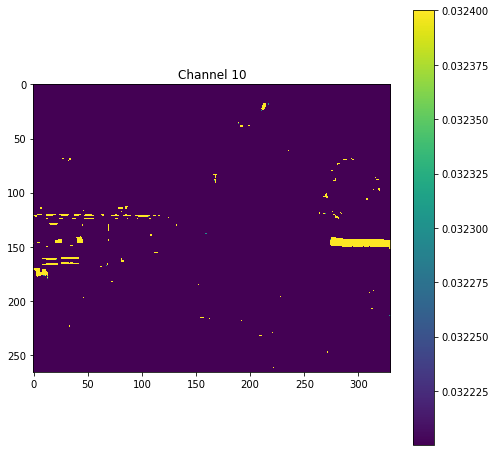

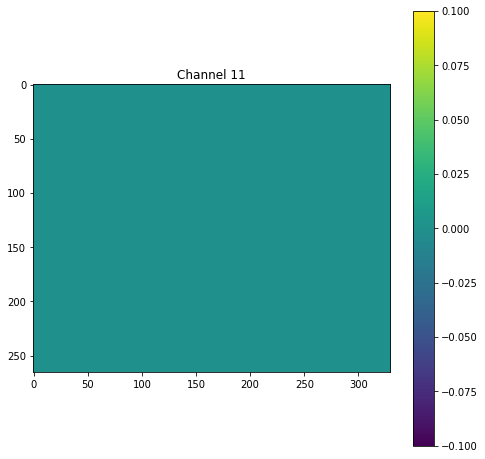

In [57]:
for i in range(num_bands):

    plt.figure(figsize=[8,8])
    plt.title("Channel "+str(i)) # fix dict code then add proper band names
    plt.imshow(image[:,:,i])
    plt.colorbar()
    plt.show()
